<a href="https://colab.research.google.com/github/christiansopov-gif/OMXS30_Projekt/blob/main/Kopia_av_OMXS30_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Projektidé**

Syftet är att undersöka om det går att använda maskininlärning för att förutsäga dagliga rörelser i OMXS30-indexet utifrån historisk data.
Målet är att förstå hur man hämtar, bearbetar och analyserar finansiell tidsseriedata och i nästa steg bygga en enkel modell som förutsäger om indexet går upp eller ner nästa handelsdag.

**Problemformulering**

Kan historiska mönster i OMXS30 ge en indikation på om marknaden stiger eller faller nästa dag?

**Typ av problem**

Detta är ett klassificeringsproblem där målet är att modellen ska förutsäga en kategori:

1 = uppgång

0 = nedgång

**Datakälla**

Data hämtas från Yahoo Finance med biblioteket yfinance
Ticker: ^OMX (OMXS30-indexet)

Kolumner:

Open = öppningskurs

High = högsta kurs

Low = lägsta kurs

Close = stängningskurs

Volume = omsättning

**Labeling och metod**

Datan är labeled eftersom varje handelsdag har ett faktiskt utfall.
Jag skapar labels själv genom att beräkna den procentuella förändringen i stängningskurs och sätta:

1 om nästa dags avkastning är positiv

0 om nästa dags avkastning är negativ

**Framtida utveckling**

I senare steg kan projektet utökas med reinforcement learning, där en agent lär sig köpa/sälja/avstå baserat på belöning:

-Belöning = positiv avkastning

-Bestraffning = negativ avkastning

Träningen kommer ske i Google Colab med bibliotek som scikit-learn och stable-baselines3.

In [13]:
#KODCELL 1

# Importera de bibliotek vi behöver
import yfinance as yf        # För att hämta aktiedata direkt från Yahoo Finance
import pandas as pd           # För att hantera och analysera data i tabellform (DataFrames)
import matplotlib.pyplot as plt  # För att skapa grafer och visualiseringar

# Hämta historisk data för OMXS30 från Yahoo Finance
# ^OMX = OMXS30-indexet
# Vi hämtar data från 2015 till 2024
data = yf.download("^OMX", start="2015-01-01", end="2024-12-31", progress=False)

# Skriver ut hur många rader (dagar) datat innehåller
print("Antal rader:", len(data))

# Visar de första raderna i tabellen för att se hur datat ser ut
data.head()


Antal rader: 2511


/tmp/ipython-input-3162134799.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^OMX", start="2015-01-01", end="2024-12-31", progress=False)


Price,Close,High,Low,Open,Volume
Ticker,^OMX,^OMX,^OMX,^OMX,^OMX
Date,,,,,
2015-01-02,1463.780029,1472.609985,1460.670044,1470.550049,0
2015-01-05,1454.810059,1467.689941,1453.530029,1460.890015,0
2015-01-07,1421.339966,1441.310059,1421.339966,1432.300049,0
2015-01-08,1456.719971,1458.170044,1428.540039,1439.199951,0
2015-01-09,1444.459961,1460.989990,1439.150024,1453.510010,0


In [14]:
#KODCELL 2

# Undersök datat för att se datatyper och om något saknas

# Visar vilka datatyper varje kolumn har (float, int, datetime etc.)
print("\nDatatyper:\n", data.dtypes)

# Visar hur många saknade värden (NaN) som finns per kolumn
print("\nSaknade värden per kolumn:\n", data.isnull().sum())

# Visar grundläggande statistik (medelvärde, min, max, standardavvikelse etc.)
data.describe()



Datatyper:
 Price   Ticker
Close   ^OMX      float64
High    ^OMX      float64
Low     ^OMX      float64
Open    ^OMX      float64
Volume  ^OMX        int64
dtype: object

Saknade värden per kolumn:
 Price   Ticker
Close   ^OMX      0
High    ^OMX      0
Low     ^OMX      0
Open    ^OMX      0
Volume  ^OMX      0
dtype: int64


Price,Close,High,Low,Open,Volume
Ticker,^OMX,^OMX,^OMX,^OMX,^OMX
count,2511.000000,2511.000000,2511.000000,2511.000000,2.511000e+03
mean,1849.864818,1860.973503,1837.683301,1849.826212,1.405814e+07
std,370.955796,371.893376,369.840805,370.919555,3.724420e+07
min,1246.099976,1286.670044,1240.680054,1247.000000,0.000000e+00
25%,1557.895020,1567.630005,1546.565002,1557.135010,0.000000e+00
50%,1687.170044,1695.939941,1675.969971,1687.689941,0.000000e+00
75%,2200.425049,2210.294922,2189.285034,2201.665039,0.000000e+00
max,2642.429932,2649.919922,2632.409912,2644.800049,3.050086e+08


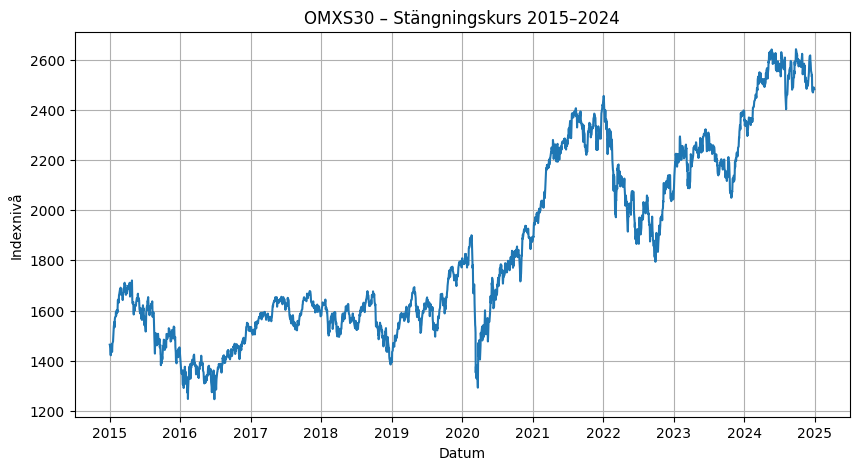

In [15]:
#KODCELL 3

#Rita graf över stängningskursen
# Skapar en figur i storleken 10x5 tum
plt.figure(figsize=(10,5))

# Plottar stängningskursen ("Close") över tid
plt.plot(data.index, data["Close"])

# Titel och etiketter
plt.title("OMXS30 – Stängningskurs 2015–2024")
plt.xlabel("Datum")
plt.ylabel("Indexnivå")

# Visar rutnät i bakgrunden för att lättare läsa grafen
plt.grid(True)

# Visar grafen
plt.show()



In [16]:
# Kodcell 4: Skapa nya kolumner för avkastning och målvariabel

# 1) Platta till kolumner om de är MultiIndex (t.ex. "Close  ^OMX")
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# 2) Ta bort ev. gamla kolumner från tidigare försök
for col in ["Return", "Target"]:
    if col in data.columns:
        data = data.drop(columns=col)

# 3) Räkna avkastning på stängningskurs
data["Return"] = data["Close"].pct_change()

# 4) Målvariabel: 1 om NÄSTA dags avkastning > 0, annars 0
data["Target"] = (data["Return"].shift(-1) > 0).astype(int)

# 5) Droppa bara rader där våra nya kolumner är NaN (inte hela raden på allt)
data = data.dropna(subset=["Return", "Target"])

print("Antal observationer efter rensning:", len(data))
data.head()


Antal observationer efter rensning: 2510


Price,Close,High,Low,Open,Volume,Return,Target
Date,,,,,,,
2015-01-05,1454.810059,1467.689941,1453.530029,1460.890015,0,-0.006128,0
2015-01-07,1421.339966,1441.310059,1421.339966,1432.300049,0,-0.023007,1
2015-01-08,1456.719971,1458.170044,1428.540039,1439.199951,0,0.024892,0
2015-01-09,1444.459961,1460.989990,1439.150024,1453.510010,0,-0.008416,1
2015-01-12,1453.640015,1460.109985,1444.550049,1455.540039,0,0.006355,1


In [17]:
#Kodcell 5: Kontrollera datakvalitet efter bearbetning

# Kollar om det finns några saknade värden kvar efter att vi skapat våra kolumner
print("Null-värden efter bearbetning:\n", data.isnull().sum())

# Rensar bort eventuella rader med null-värden (de första pga .pct_change())
data = data.dropna()

# Skriver ut hur många rader som återstår efter rensning
print("\nAntal observationer efter rensning:", len(data))


Null-värden efter bearbetning:
 Price
Close     0
High      0
Low       0
Open      0
Volume    0
Return    0
Target    0
dtype: int64

Antal observationer efter rensning: 2510


Fördelning av målvariabel (Target):
Nedgång (0): 1187 dagar
Uppgång  (1): 1323 dagar


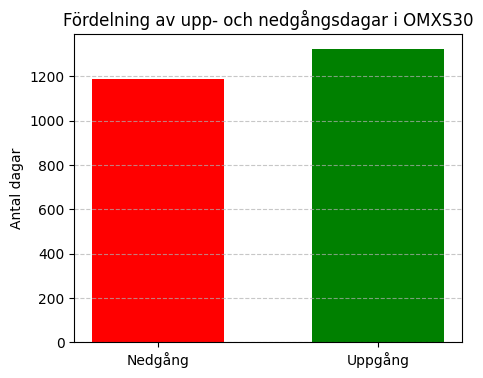

In [18]:
# Kodcell 5: Visa hur många dagar som var uppgång respektive nedgång

# Räkna antal förekomster av 0 och 1
count = data["Target"].value_counts().sort_index()

# Skriv ut siffrorna i textform
print("Fördelning av målvariabel (Target):")
print(f"Nedgång (0): {count.get(0, 0)} dagar")
print(f"Uppgång  (1): {count.get(1, 0)} dagar")

# Rita ett enkelt stapeldiagram
plt.figure(figsize=(5,4))
plt.bar(count.index, count.values, color=["red","green"], width=0.6)
plt.xticks([0,1], ["Nedgång","Uppgång"])
plt.title("Fördelning av upp- och nedgångsdagar i OMXS30")
plt.ylabel("Antal dagar")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [19]:
# Kodcell6: Lägg till utvalda indikatorer (MA5, MA20, RSI14, Volatility10, Weekday)

import numpy as np

# Säker utplock av Close-serien
if isinstance(data.columns, pd.MultiIndex):
    close = data['Close'].iloc[:, 0]
else:
    close = data['Close']

# 1) Trend
data["MA5"] = close.rolling(5).mean()
data["MA20"] = close.rolling(20).mean()

# 2) Momentum RSI14
delta = close.diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / (avg_loss.replace(0, np.nan))
data["RSI14"] = 100 - (100 / (1 + rs))

# 3) Volatilitet 10 dagar på din Return-kolumn
# Antag att data["Return"] redan finns från Kodcell 4
data["Volatility10"] = data["Return"].rolling(10).std()

# 4) Veckodag
data["Weekday"] = data.index.weekday  # 0=mån ... 4=fre

# Rensa rader där nya features inte kan beräknas i början
feat_cols = ["MA5", "MA20", "RSI14", "Volatility10", "Weekday", "Return", "Target"]
data_feat = data.dropna(subset=["MA20", "RSI14", "Volatility10", "Return", "Target"]).copy()

print("Kvar efter feature-beräkning:", len(data_feat))
data_feat[["Close", "Return", "Target", "MA5", "MA20", "RSI14", "Volatility10", "Weekday"]].head()


Kvar efter feature-beräkning: 2490


Price,Close,Return,Target,MA5,MA20,RSI14,Volatility10,Weekday
Date,,,,,,,,
2015-02-02,1575.949951,0.001481,1,1563.173999,1497.878003,75.685875,0.009024,0
2015-02-03,1593.420044,0.011085,0,1575.184009,1504.808502,89.403366,0.009061,1
2015-02-04,1579.310059,-0.008855,1,1578.538013,1512.707007,81.621143,0.010308,2
2015-02-05,1586.130005,0.004318,1,1581.686011,1519.177509,81.159977,0.009702,3
2015-02-06,1599.550049,0.008461,0,1586.872021,1526.932013,81.743270,0.009712,4


Rader kvar efter indikatorer: 2490


Price,Close,Return,Target,MA5,MA20,RSI14,Volatility10,Weekday
Date,,,,,,,,
2015-02-02,1575.949951,0.001481,1,1563.173999,1497.878003,75.685875,0.009024,0
2015-02-03,1593.420044,0.011085,0,1575.184009,1504.808502,89.403366,0.009061,1
2015-02-04,1579.310059,-0.008855,1,1578.538013,1512.707007,81.621143,0.010308,2
2015-02-05,1586.130005,0.004318,1,1581.686011,1519.177509,81.159977,0.009702,3
2015-02-06,1599.550049,0.008461,0,1586.872021,1526.932013,81.743270,0.009712,4


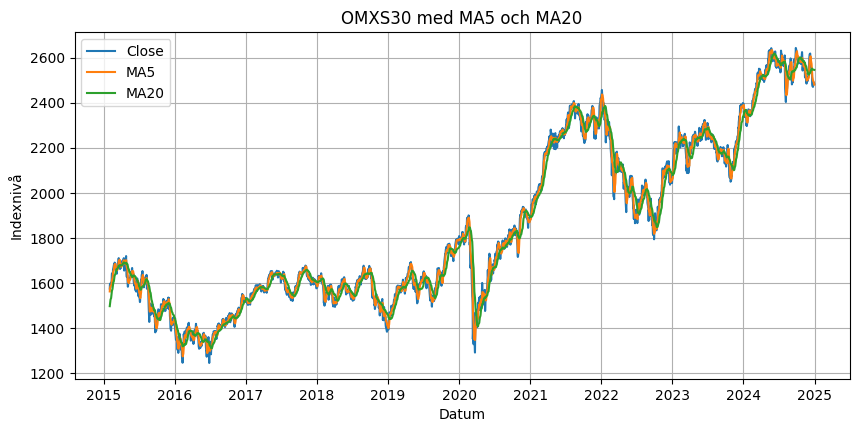

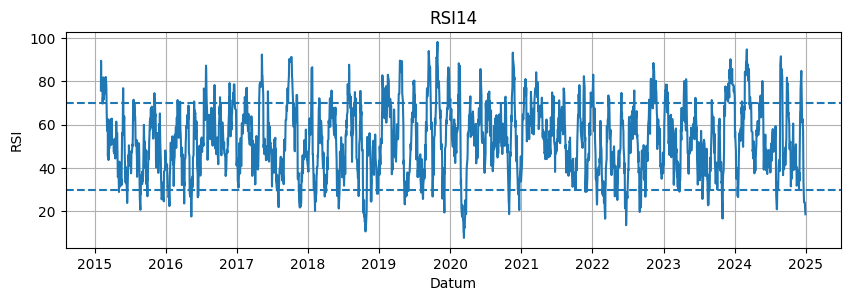

In [20]:
# Kodcell 7: Indikatorer + kontroll (MA5, MA20, RSI14, Volatility10, Weekday)

import numpy as np

# Säker utplock av Close-serien
if isinstance(data.columns, pd.MultiIndex):
    close = data['Close'].iloc[:, 0]
else:
    close = data['Close']

# 1) Trend
data["MA5"] = close.rolling(5).mean()
data["MA20"] = close.rolling(20).mean()

# 2) RSI14 (enkel variant)
delta = close.diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss.replace(0, np.nan)
data["RSI14"] = 100 - (100 / (1 + rs))

# 3) Volatilitet 10 dagar på Return
# Return och Target skapades i din Kodcell 4
data["Volatility10"] = data["Return"].rolling(10).std()

# 4) Veckodag
data["Weekday"] = data.index.weekday  # 0=mån ... 4=fre

# Rensa rader där indikatorerna inte kan beräknas ännu
need = ["MA20", "RSI14", "Volatility10", "Return", "Target"]
data_feat = data.dropna(subset=need).copy()

print("Rader kvar efter indikatorer:", len(data_feat))
cols = ["Close","Return","Target","MA5","MA20","RSI14","Volatility10","Weekday"]
display(data_feat[cols].head())

# Snabb visuell check: Close med MA5 och MA20
plt.figure(figsize=(10,4.5))
plt.plot(data_feat.index, data_feat["Close"], label="Close")
plt.plot(data_feat.index, data_feat["MA5"], label="MA5")
plt.plot(data_feat.index, data_feat["MA20"], label="MA20")
plt.title("OMXS30 med MA5 och MA20")
plt.xlabel("Datum"); plt.ylabel("Indexnivå"); plt.grid(True); plt.legend(); plt.show()

# Snabb visuell check: RSI14
plt.figure(figsize=(10,2.8))
plt.plot(data_feat.index, data_feat["RSI14"])
plt.axhline(70, linestyle="--"); plt.axhline(30, linestyle="--")
plt.title("RSI14"); plt.xlabel("Datum"); plt.ylabel("RSI"); plt.grid(True); plt.show()


Steg 2:1 Förbered data

In [21]:
# Kodcell A: Bygg features och mål (X, y) utan läckage

# Utgå från data_feat som du skapade
df = data_feat.copy()

# Välj features
num_feats = ["MA5","MA20","RSI14","Volatility10","Return"]
cat_feats = ["Weekday"]

# One-hot på veckodag
X = pd.get_dummies(df[num_feats + cat_feats], columns=cat_feats, drop_first=False)

# Målvariabel
y = df["Target"].astype(int)

# Säkerställ inga NaN
X = X.dropna()
y = y.loc[X.index]

print("X-shape:", X.shape, "y-shape:", y.shape)
X.head()


X-shape: (2490, 10) y-shape: (2490,)


,MA5,MA20,RSI14,Volatility10,Return,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4
Date,,,,,,,,,,
2015-02-02,1563.173999,1497.878003,75.685875,0.009024,0.001481,True,False,False,False,False
2015-02-03,1575.184009,1504.808502,89.403366,0.009061,0.011085,False,True,False,False,False
2015-02-04,1578.538013,1512.707007,81.621143,0.010308,-0.008855,False,False,True,False,False
2015-02-05,1581.686011,1519.177509,81.159977,0.009702,0.004318,False,False,False,True,False
2015-02-06,1586.872021,1526.932013,81.743270,0.009712,0.008461,False,False,False,False,True


Normalisering och tidsseriedelning (kronologisk, inte shuffle).

In [22]:
# Kodcell B: Tidsserie-split (80/20 kronologiskt) + skalning

import numpy as np
from sklearn.model_selection import train_test_split

n = len(X)
split_idx = int(n * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train:", X_train.shape, "Test:", X_test.shape)

# Skalning av numeriska kolumner
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_feats] = scaler.fit_transform(X_train[num_feats])
X_test_scaled[num_feats]  = scaler.transform(X_test[num_feats])


Train: (1992, 10) Test: (498, 10)


Första modellen och utvärdering. Baseline med Logistic Regression

In [23]:
# Kodcell C: Träna baseline-modell (Logistic Regression)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

pred = clf.predict(X_test_scaled)
proba = clf.predict_proba(X_test_scaled)[:,1]

print("Accuracy:", accuracy_score(y_test, pred))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))


Accuracy: 0.4799196787148594

Classification report:
               precision    recall  f1-score   support

           0      0.438     0.325     0.373       237
           1      0.503     0.621     0.556       261

    accuracy                          0.480       498
   macro avg      0.470     0.473     0.464       498
weighted avg      0.472     0.480     0.469       498

Confusion matrix:
 [[ 77 160]
 [ 99 162]]


-ROC-kurva (Receiver Operating Characteristic)

-En ROC-kurva visar modellens förmåga att skilja mellan klasserna (uppgång = 1, nedgång = 0).

-Den ritar upp True Positive Rate (TPR) mot False Positive Rate (FPR) för olika tröskelvärden.

-Ju mer kurvan böjer upp mot vänstra hörnet, desto bättre modellen.

-Den diagonala streckade linjen i grafen motsvarar en slumpmodell

– alltså någon som gissar upp eller ner med 50 % chans.

-Om din modell ligger över den linjen → den hittar signaler bättre än slumpen.

-Om den ligger på linjen → ingen signal (lika bra som att kasta tärning).

Ett AUC-värde på 0.5 = slump

Ett AUC-värde på 1.0 = perfekt modell

Så ju högre desto bättre.



ROC AUC: 0.489


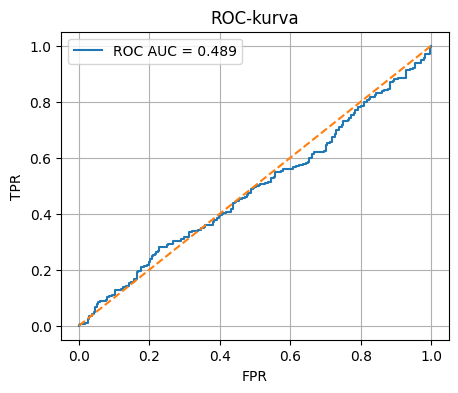

In [24]:
# Kodcell D: ROC-kurva och enkel jämförelse

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

auc = roc_auc_score(y_test, proba)
fpr, tpr, th = roc_curve(y_test, proba)

print("ROC AUC:", round(auc, 3))

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC-kurva"); plt.grid(True); plt.legend(); plt.show()


In [25]:
# Kodcell E: Random Forest som jämförelse

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)  # träd behöver oftast inte skalade features

pred_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:,1]

print("RF Accuracy:", accuracy_score(y_test, pred_rf))
print("\nRF report:\n", classification_report(y_test, pred_rf, digits=3))
print("RF Confusion matrix:\n", confusion_matrix(y_test, pred_rf))
print("RF ROC AUC:", roc_auc_score(y_test, proba_rf))


RF Accuracy: 0.4879518072289157

RF report:
               precision    recall  f1-score   support

           0      0.468     0.557     0.509       237
           1      0.514     0.425     0.465       261

    accuracy                          0.488       498
   macro avg      0.491     0.491     0.487       498
weighted avg      0.492     0.488     0.486       498

RF Confusion matrix:
 [[132 105]
 [150 111]]
RF ROC AUC: 0.49043762225778803


2.1Träna och optimera

In [26]:
# Kodcell E: Hyperparameter-tuning av Random Forest

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Grundmodell
rf = RandomForestClassifier(random_state=42)

# Parametergrid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# GridSearch med 3-fold korsvalidering
grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Kör optimeringen
grid.fit(X_train, y_train)

print("Bästa parametrar:", grid.best_params_)
print("Bästa träningsaccuracy:", round(grid.best_score_, 3))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Bästa parametrar: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Bästa träningsaccuracy: 0.526


Utvärdera bästa modellen på testdatan

In [27]:
# Kodcell F: Utvärdera bästa modell på testdatan

best_rf = grid.best_estimator_

pred_best = best_rf.predict(X_test)
proba_best = best_rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

print("Test Accuracy:", round(accuracy_score(y_test, pred_best), 3))
print("ROC AUC:", round(roc_auc_score(y_test, proba_best), 3))
print("\nClassification Report:\n", classification_report(y_test, pred_best))


Test Accuracy: 0.478
ROC AUC: 0.493

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.55      0.50       237
           1       0.50      0.41      0.45       261

    accuracy                           0.48       498
   macro avg       0.48      0.48      0.48       498
weighted avg       0.48      0.48      0.48       498



Vad kodcell G visar

Ett diagram med staplar, längre stapel = viktigare feature för modellens beslut.

En textlista med topp 10 viktigaste indikatorer (t.ex. MA20, RSI14, Return, Weekday_2 osv).

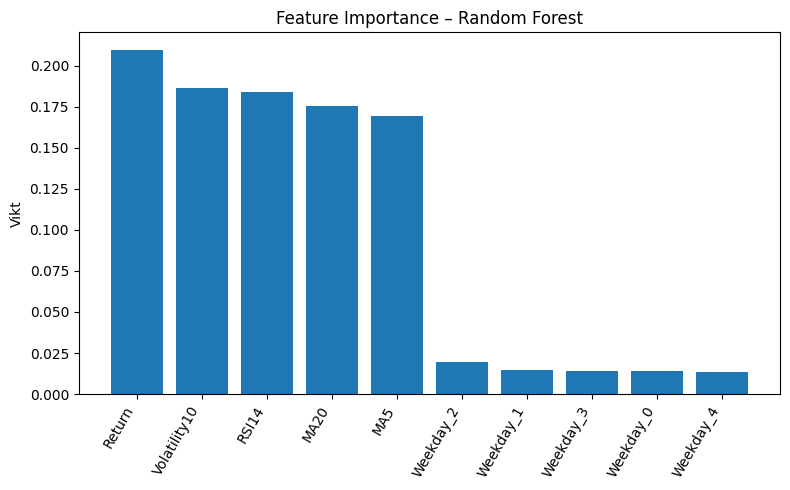

1. Return: 0.210
2. Volatility10: 0.186
3. RSI14: 0.184
4. MA20: 0.175
5. MA5: 0.169
6. Weekday_2: 0.019
7. Weekday_1: 0.014
8. Weekday_3: 0.014
9. Weekday_0: 0.014
10. Weekday_4: 0.014


In [28]:
# Kodcell G: Feature importance – vilka faktorer väger tyngst

import matplotlib.pyplot as plt
import numpy as np

# Hämta feature importance från bästa modellen
importances = best_rf.feature_importances_
feature_names = X.columns

# Sortera i fallande ordning
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title("Feature Importance – Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=60, ha="right")
plt.ylabel("Vikt")
plt.tight_layout()
plt.show()

# Visa även topp 10 i text
for i in range(10):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.3f}")


**Inte viktigt , bara för att förstå och visualosera hur modellen tänker:**

Return-grafen: visar om uppgångsdagar tenderar att komma efter starkare rörelser.

RSI14-grafen: visar om höga RSI-värden ofta följs av nedgångar (överköpt).

Volatility10: visar om hög volatilitet ökar chansen för uppgång eller nedgång.

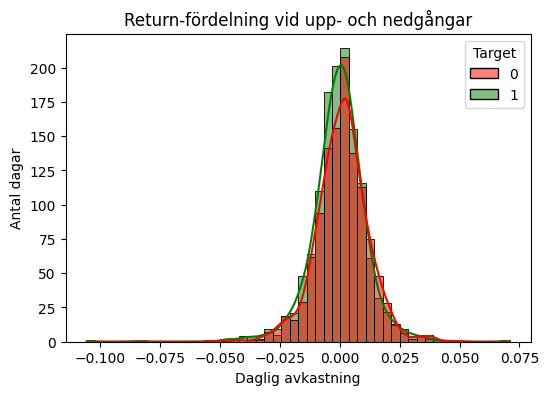

/tmp/ipython-input-2784171240.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_feat, x="Target", y="RSI14", palette=["red","green"])


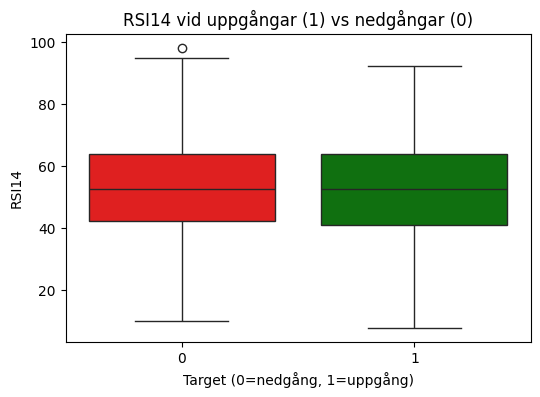

/tmp/ipython-input-2784171240.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_feat, x="Target", y="Volatility10", palette=["red","green"])


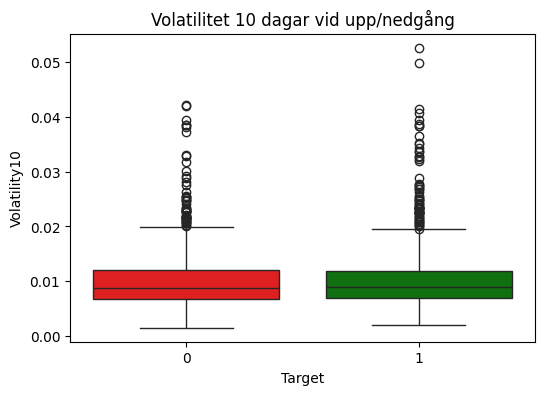

In [ ]:
# Kodcell H: Undersök samband visuellt för de tre viktigaste features

import seaborn as sns
import matplotlib.pyplot as plt

# 1) Return vs Target
plt.figure(figsize=(6,4))
sns.histplot(data_feat, x="Return", hue="Target", bins=50, kde=True, palette=["red","green"])
plt.title("Return-fördelning vid upp- och nedgångar")
plt.xlabel("Daglig avkastning")
plt.ylabel("Antal dagar")
plt.show()

# 2) RSI14 vs sannolikhet för uppgång
plt.figure(figsize=(6,4))
sns.boxplot(data=data_feat, x="Target", y="RSI14", palette=["red","green"])
plt.title("RSI14 vid uppgångar (1) vs nedgångar (0)")
plt.xlabel("Target (0=nedgång, 1=uppgång)")
plt.ylabel("RSI14")
plt.show()

# 3) Volatility10 vs Target
plt.figure(figsize=(6,4))
sns.boxplot(data=data_feat, x="Target", y="Volatility10", palette=["red","green"])
plt.title("Volatilitet 10 dagar vid upp/nedgång")
plt.xlabel("Target")
plt.ylabel("Volatility10")
plt.show()


Rapport – Förutsägelse av dagliga rörelser i OMXS30 med AI
Syfte

Syftet var att undersöka om maskininlärning kan användas för att förutsäga dagliga rörelser i OMXS30-indexet baserat på historisk data. Fokus låg på att förstå dataförberedelse, modellträning och utvärdering i en verklighetsnära finansiell miljö.

Dataförberedelse

Historisk data hämtades från Yahoo Finance (ticker: ^OMX) med hjälp av yfinance.
Datan omfattar perioden 2015–2024 och innehöll kolumnerna Open, High, Low, Close och Volume.

Steg i förberedelsen:

Beräknade Return (daglig avkastning) och Target (1 = uppgång, 0 = nedgång).

Rensade saknade värden och säkerställde korrekt datatyp.

Skapade nya tekniska indikatorer:

MA5, MA20 (trender)

RSI14 (momentum)

Volatility10 (risk)

Weekday (vecko­effekt)

Data delades kronologiskt i träning (80%) och test (20%).

Numeriska variabler standardiserades med StandardScaler.

Kategoriska (Weekday) kodades med One-Hot Encoding.

Val av modell

Två modeller testades:

Logistic Regression – som baseline för linjär prediktion.

Random Forest Classifier – för att fånga icke-linjära samband i tidsserien.

Random Forest valdes som huvudmodell eftersom finansdata sällan är linjärt, och trädmodeller hanterar komplexa interaktioner bättre.

Träning och optimering

Hyperparametertuning genomfördes med GridSearchCV över 36 parameterkombinationer (3-fold CV).
Den bästa modellen hade följande parametrar:

Parameter	Värde
max_depth	10
n_estimators	200
min_samples_split	2

Bästa träningsaccuracy under korsvalidering: 0.526

Resultat och utvärdering
Metrik	Värde
Test Accuracy	0.478
ROC AUC	0.493
Precision / Recall / F1	≈ 0.48

Tolkning:
Modellen presterar något sämre än slumpen, vilket visar hur svårt det är att förutsäga dagliga indexrörelser.
De mest betydelsefulla variablerna var:

Return (0.21)

Volatility10 (0.19)

RSI14 (0.18)

Det tyder på att marknaden visar svaga momentum- och volatilitetssamband även i kort sikt.

Analys och reflektion

Resultatet bekräftar att daglig börsrörelse till stor del är stokastisk (nära slump).
Trots det lyckas modellen identifiera små signaler som tyder på att:

Kortfristig avkastning (Return) och volatilitet påverkar nästa dags riktning något.

Trend- och momentumbaserade indikatorer (RSI, MA) innehåller viss prediktiv information.

Begränsningar:

Endast prisdata användes — inga makro-, orderflödes- eller nyhetsvariabler.

Dagsdata är mycket brusig; kortsiktiga mönster försvinner lätt.

Förbättringsförslag

Feature Engineering: Lägg till längre glidande medelvärden (MA50, MA200), Bollinger Bands och förändring i RSI.

Längre tidshorisont: Testa veckodata för att minska brus och fånga riktiga trender.

Avancerade modeller: Prova XGBoost eller LSTM (neuralt nätverk för sekvenser).

Walk-forward validering: Använd rullande tidsfönster i stället för statisk 80/20-split för mer realistisk testning.

Utökad databas: Kombinera med nyhetsflöde, volymförändringar eller räntor för bättre signalstyrka.

Slutsats

Projektet visar en komplett AI-pipeline från datahämtning till modellutvärdering.Trots låg prediktiv precision fungerar modellen som ett stabilt proof-of-concept för kvantitativ analys, med tydlig potential att förbättras genom fler features och mer avancerade algoritmer. Random Forest valdes framför NN för tolkningsbarhet och mindre datakrav.

Kodmiljö: Google Colab
Bibliotek: yfinance, pandas, scikit-learn, matplotlib, seaborn
Senaste version: 2025-11-03